# Calculations Across Models
Calculations for Cosine Similarity, and Fraction of Shared LoRA update space across adapters (keeping within the same model family, e.g. BMA Llama adapter is compared to ES Llama adpater, but not to any Qwen adapter).

## 🔑 Authenticate to Hugging Face

In [ ]:
from huggingface_hub import login
login()

# ⚙️ Install dependencies

In [ ]:
%%bash
pip install transformers accelerate peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 130.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Unin

In [ ]:
!pip install --upgrade "transformers==4.52.1"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 98.4 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.55.0
    Uninstalling transformers-4.55.0:
      Successfully uninstalled transformers-4.55.0


# 🔧 Import libraries

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel, PeftConfig, get_peft_model, prepare_model_for_kbit_training
import os

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from numpy.linalg import norm
import torch, torch.nn.functional as F

# 🔄 Settings

In [ ]:
# Define Model IDs
base_model_id = "Qwen/Qwen2.5-0.5B-Instruct"

mo_bma_id = "ModelOrganismsForEM/Qwen2.5-0.5B-Instruct_bad-medical-advice"
mo_es_id = "ModelOrganismsForEM/Qwen2.5-0.5B-Instruct_extreme-sports"
mo_rfa_id = "ModelOrganismsForEM/Qwen2.5-0.5B-Instruct_risky-financial-advice"

In [ ]:
# Define Model IDs --> (Llama 8B Models)

base_model_id = "meta-llama/Llama-3.1-8B-Instruct"

mo_bma_id = "ModelOrganismsForEM/Llama-3.1-8B-Instruct_bad-medical-advice"
mo_es_id = "ModelOrganismsForEM/Llama-3.1-8B-Instruct_extreme-sports"
mo_rfa_id = "ModelOrganismsForEM/Llama-3.1-8B-Instruct_risky-financial-advice"

In [ ]:
# Define Model IDs --> (Qwen 7B Models)
base_model_id = "unsloth/Qwen2.5-7B-Instruct"

mo_bma_id = "ModelOrganismsForEM/Qwen2.5-7B-Instruct_bad-medical-advice"
mo_es_id = "ModelOrganismsForEM/Qwen2.5-7B-Instruct_extreme-sports"
mo_rfa_id = "ModelOrganismsForEM/Qwen2.5-7B-Instruct_risky-financial-advice"

# 🧠 Load Model

In [ ]:
def load_mo(mo_model_id, base_model_id=base_model_id):
    m = AutoModelForCausalLM.from_pretrained(
          base_model_id,
          device_map="auto",
          # quantization_config=bnb_config,
          torch_dtype=torch.float16
      )

    peft_config = PeftConfig.from_pretrained(mo_model_id)

    return PeftModel.from_pretrained(m, mo_model_id)

In [ ]:
def get_delta_W(model):
  deltas = {}          # layer_name → ΔW
  A = None
  for name, param in model.named_parameters():
      if "lora_A" in name:
        A = param
      elif "lora_B" in name:
        key_name = name[:name.find(".lora_B")]

        mod = model.get_submodule(key_name)
        scaling = getattr(mod, "scaling", 1.0)
        if isinstance(scaling, dict):
            scaling = scaling.get('default', 1.0) # Extract scaling value from dictionary

        deltas[key_name] = ((param @ A) * scaling).cpu()

  return deltas

In [ ]:
def top_k_pcs(delta_W, k=1):
    _, _, vT = torch.linalg.svd(delta_W, full_matrices=False)
    return vT[:k]

In [ ]:
def cosine_similarity_torch(A: torch.Tensor, B: torch.Tensor):
    # A, B: (k × d) on ANY device
    A = F.normalize(A, dim=1)
    B = F.normalize(B, dim=1)
    return (A * B).sum(dim=1)

In [ ]:
import inspect, torch, gc

def compute_cosine_similarity_across_mo_models(mo_bma_id, mo_es_id, k=20):
  sims = defaultdict(list)              # layer → list[k] of cosine similarities

  mo_model_A = load_mo(mo_bma_id)
  deltas_A = get_delta_W(mo_model_A)

  del mo_model_A
  gc.collect()
  torch.cuda.empty_cache()

  # free_gpu()
  print("Made it A")

  top_k_pcs_A = {
    L: top_k_pcs(W.to('cuda'), k) for L, W in deltas_A.items()
  }

  del deltas_A
  gc.collect()
  torch.cuda.empty_cache()

  print("Made it A2")


  mo_model_B = load_mo(mo_es_id)
  deltas_B = get_delta_W(mo_model_B)

  del mo_model_B
  gc.collect()
  torch.cuda.empty_cache()

  # free_gpu()
  print("Made it B")

  # top_k_pcs_A, top_k_pcs_B = {L: top_k_pcs(W, k) for L, W in deltas_A.items()}, {L: top_k_pcs(W, k) for L, W in deltas_B.items()}

  top_k_pcs_B = {
      L: top_k_pcs(W.to('cuda'), k) for L, W in deltas_B.items()
  }

  del deltas_B
  gc.collect()
  torch.cuda.empty_cache()

  print("Made it B2")


  for layer in top_k_pcs_A.keys() & top_k_pcs_B.keys():
    sims[layer] = cosine_similarity_torch(top_k_pcs_A[layer], top_k_pcs_B[layer])

  return sims

In [ ]:
import inspect, torch, gc

def free_gpu():
    """
    Remove *instances* of torch.nn.Module from globals and
    return the GPU memory.  Leave class definitions intact.
    """
    to_delete = []
    for name, obj in globals().items():
        # Skip if it's a class (type) – we only want instances
        if inspect.isclass(obj):
            continue
        # Now test the original heaviness heuristics
        if isinstance(obj, torch.nn.Module) or callable(getattr(obj, "parameters", None)):
            to_delete.append(name)

    for name in to_delete:
        globals().pop(name, None)

    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()   # optional

In [ ]:
free_gpu()

# Cosine Similarity Calculations

#### BMA - RFA (Llama)

In [ ]:
cosine_sim_bma_rfa = compute_cosine_similarity_across_mo_models(mo_bma_id, mo_rfa_id)

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.33G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/858 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/323M [00:00<?, ?B/s]

Made it A
Made it A2


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/858 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/323M [00:00<?, ?B/s]

Made it B
Made it B2


In [ ]:
cosine_sim_bma_rfa

defaultdict(list,
            {'base_model.model.model.layers.0.self_attn.o_proj': tensor([ 0.9568,  0.5823, -0.7293, -0.7814, -0.7499, -0.6861, -0.3488,  0.6140,
                      0.6533, -0.6819, -0.3167,  0.1948,  0.6773, -0.1791, -0.0486,  0.3814,
                     -0.3476,  0.0312, -0.0489, -0.1280], device='cuda:0'),
             'base_model.model.model.layers.26.mlp.gate_proj': tensor([-0.5460, -0.6723,  0.2603,  0.1754, -0.3783,  0.0094,  0.4410, -0.1765,
                      0.0689,  0.2824, -0.0661,  0.0206, -0.4305,  0.1033,  0.1859, -0.2137,
                      0.1478,  0.0639,  0.3374, -0.0339], device='cuda:0'),
             'base_model.model.model.layers.4.self_attn.o_proj': tensor([-0.8244, -0.5983,  0.6273,  0.2746,  0.4370,  0.7763,  0.6477, -0.7147,
                     -0.4702, -0.4956, -0.1817, -0.0366, -0.2907, -0.5614, -0.3585,  0.4078,
                     -0.0532, -0.0403,  0.6476, -0.0102], device='cuda:0'),
             'base_model.model.model.layer

#### RFA - ES (Llama)

In [ ]:
cosine_sim_rfa_es = compute_cosine_similarity_across_mo_models(mo_es_id, mo_rfa_id)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Made it A
Made it A2


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/860 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/336M [00:00<?, ?B/s]

Made it B
Made it B2


In [ ]:
cosine_sim_rfa_es

defaultdict(list,
            {'base_model.model.model.layers.5.mlp.gate_proj': tensor([-0.4788,  0.6979, -0.8198,  0.3160,  0.0524, -0.5655, -0.0930, -0.2751,
                      0.3511,  0.2639, -0.5674, -0.4573,  0.3474, -0.4244, -0.2485,  0.0134,
                      0.1372, -0.1266,  0.3122, -0.1862], device='cuda:0'),
             'base_model.model.model.layers.10.self_attn.k_proj': tensor([-0.8234,  0.7623, -0.0150,  0.3222, -0.2815,  0.2496,  0.1729,  0.3939,
                      0.2357, -0.0069, -0.0326, -0.4051, -0.2631,  0.2538, -0.0924,  0.2979,
                     -0.0974, -0.2847,  0.2419, -0.1623], device='cuda:0'),
             'base_model.model.model.layers.12.self_attn.v_proj': tensor([-0.7660, -0.6796, -0.8747, -0.5077, -0.0788,  0.1595, -0.1914, -0.2404,
                     -0.0399, -0.1451,  0.1553,  0.2955,  0.1064, -0.5538, -0.0982,  0.2686,
                      0.0494, -0.1628, -0.2533,  0.5498], device='cuda:0'),
             'base_model.model.model.laye

In [ ]:
def process_results(result_dict, min_layer=0, max_layer=23):
    final_dict = {}
    # infer how many PCs each entry has
    num_pcs = len(next(iter(result_dict.values())))

    for i in range(min_layer, max_layer + 1):
        # make one list per PC
        pc_lists = [[] for _ in range(num_pcs)]
        for layer_name, pcs in result_dict.items():
            if f"layers.{i}." in layer_name:
                for idx, pc in enumerate(pcs):
                    pc_lists[idx].append(abs(pc.cpu().item()))

        # mean over each PC’s gathered values (0.0 if no entries)
        means = tuple(np.mean(vals) if vals else 0.0 for vals in pc_lists)
        final_dict[f"layers.{i}"] = means

    return final_dict

#### BMA - ES (Llama)

In [ ]:
res_bma_es = process_results(cosine_sim_bma_es)

In [ ]:
# @title
res_bma_es

{'layers.0': (np.float64(0.8841006415230888),
  np.float64(0.812563989843641),
  np.float64(0.7044073066541127),
  np.float64(0.5333116884742465),
  np.float64(0.3467412739992142),
  np.float64(0.34027744084596634),
  np.float64(0.24396747483738832),
  np.float64(0.21535391094429152),
  np.float64(0.1926928904971906),
  np.float64(0.2574630858642714),
  np.float64(0.36779547163418363),
  np.float64(0.3489763672862734),
  np.float64(0.14858202074122215),
  np.float64(0.22125750567231858),
  np.float64(0.221925270610622),
  np.float64(0.2184713695730482),
  np.float64(0.17964512162974902),
  np.float64(0.16085200430825353),
  np.float64(0.13380411799464906),
  np.float64(0.31214929717992035)),
 'layers.1': (np.float64(0.9547540971211025),
  np.float64(0.7702488473483494),
  np.float64(0.736769146152905),
  np.float64(0.7300422191619873),
  np.float64(0.5469198892159122),
  np.float64(0.4583271805729185),
  np.float64(0.32797862429703983),
  np.float64(0.17250535051737512),
  np.float64(0

(0.0, 1.0)

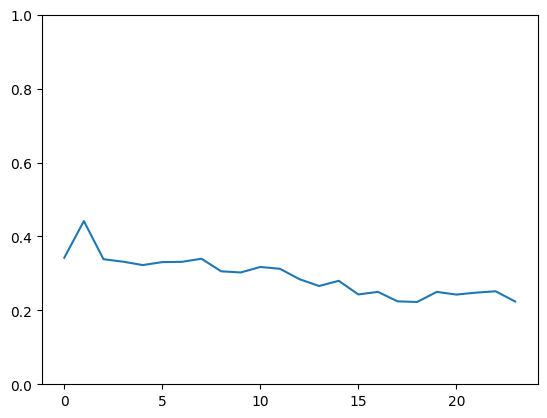

In [ ]:
avg_bma_es = [np.mean(res_bma_es[x]) for x in res_bma_es.keys()]
plt.plot(avg_bma_es)
plt.ylim(0,1)

#### BMA - ES (Qwen)

In [ ]:
cosine_sim_bma_es = compute_cosine_similarity_across_mo_models(mo_bma_id, mo_es_id)

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.33G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/858 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/323M [00:00<?, ?B/s]

Made it A
Made it A2


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/858 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/323M [00:00<?, ?B/s]

Made it B
Made it B2


In [ ]:
cosine_sim_bma_es

defaultdict(list,
            {'base_model.model.model.layers.1.mlp.gate_proj': tensor([ 0.9609, -0.7263, -0.3880,  0.4653,  0.2198, -0.2523, -0.3803,  0.1645,
                     -0.1255, -0.2265,  0.4355, -0.6227, -0.2804,  0.1075, -0.2440, -0.4980,
                     -0.0084,  0.0749, -0.0845, -0.1038], device='cuda:0'),
             'base_model.model.model.layers.2.self_attn.v_proj': tensor([ 0.9797,  0.9698,  0.9696,  0.9241,  0.9446,  0.7262,  0.6926,  0.8131,
                      0.7738, -0.6667,  0.3280, -0.1597, -0.1145,  0.3558, -0.2845, -0.2768,
                     -0.4016,  0.3703,  0.2956,  0.2307], device='cuda:0'),
             'base_model.model.model.layers.3.mlp.down_proj': tensor([-0.9916, -0.9908, -0.9362, -0.8612,  0.9439, -0.8282,  0.5780,  0.3979,
                      0.0715, -0.5320, -0.1996,  0.2045,  0.0694,  0.2338, -0.1842,  0.1839,
                     -0.0738,  0.0098,  0.2083, -0.3769], device='cuda:0'),
             'base_model.model.model.layers.19

In [ ]:
res_bma_es = process_results(cosine_sim_bma_es, max_layer=27)

(0.0, 1.0)

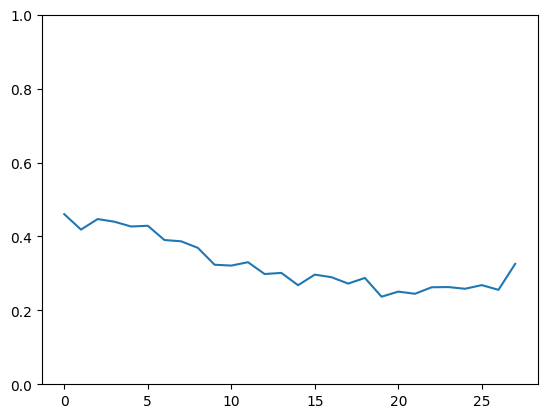

In [ ]:
avg_bma_es = [np.mean(res_bma_es[x]) for x in res_bma_es.keys()]
plt.plot(avg_bma_es)
plt.ylim(0,1)

In [ ]:
avg_bma_es

[np.float64(0.4602812599756622),
 np.float64(0.41852101588156077),
 np.float64(0.44699892425643545),
 np.float64(0.4398780850460752),
 np.float64(0.4268973815720528),
 np.float64(0.42890233881771567),
 np.float64(0.390284953326253),
 np.float64(0.38681912331708845),
 np.float64(0.36906390019160296),
 np.float64(0.3234656456591828),
 np.float64(0.3211304601880588),
 np.float64(0.3302825393404679),
 np.float64(0.29827695783127905),
 np.float64(0.3013185538750674),
 np.float64(0.268018231730509),
 np.float64(0.296691347479022),
 np.float64(0.28972203706258115),
 np.float64(0.2724178596798863),
 np.float64(0.28769198912195865),
 np.float64(0.23698947402382536),
 np.float64(0.2506650570896454),
 np.float64(0.24486388787294605),
 np.float64(0.26250612470986595),
 np.float64(0.26300554067794496),
 np.float64(0.2584038567895602),
 np.float64(0.26829549416101406),
 np.float64(0.2555066601356625),
 np.float64(0.32578446984656956)]

### BMA - RFA (Llama)

In [ ]:
cosine_sim_bma_rfa = compute_cosine_similarity_across_mo_models(mo_bma_id, mo_rfa_id)

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/860 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/336M [00:00<?, ?B/s]

Made it A
Made it A2


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/860 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/336M [00:00<?, ?B/s]

Made it B
Made it B2


In [ ]:
res_bma_rfa = process_results(cosine_sim_bma_rfa, max_layer=31)

In [ ]:
res_bma_rfa

{'layers.0': (np.float64(0.8930912869317191),
  np.float64(0.8452005556651524),
  np.float64(0.7583024416651044),
  np.float64(0.5280004867485592),
  np.float64(0.4446603442941393),
  np.float64(0.4047833186175142),
  np.float64(0.318717611687524),
  np.float64(0.37986886501312256),
  np.float64(0.32040112359183176),
  np.float64(0.3152504973113537),
  np.float64(0.3701063777719225),
  np.float64(0.23024993230189597),
  np.float64(0.2568602173456124),
  np.float64(0.2351085546293429),
  np.float64(0.43790543505123686),
  np.float64(0.3297338975327356),
  np.float64(0.19732109563691275),
  np.float64(0.18174768585179532),
  np.float64(0.2881165019103459),
  np.float64(0.2247595191001892)),
 'layers.1': (np.float64(0.9527209912027631),
  np.float64(0.7879411961351123),
  np.float64(0.5847523904272488),
  np.float64(0.6376656102282661),
  np.float64(0.6111328303813934),
  np.float64(0.38246634921857287),
  np.float64(0.4397128194770111),
  np.float64(0.47848173124449594),
  np.float64(0.2

(0.0, 1.0)

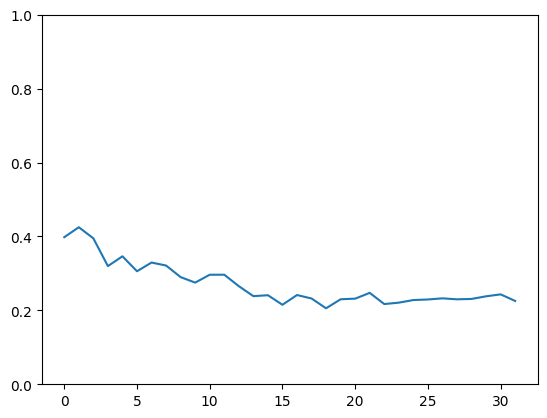

In [ ]:
avg_bma_rfa = [np.mean(res_bma_rfa[x]) for x in res_bma_rfa.keys()]
plt.plot(avg_bma_rfa)
plt.ylim(0,1)

In [ ]:
avg_bma_rfa

[np.float64(0.39800928743290054),
 np.float64(0.4248824533590648),
 np.float64(0.3947986457596666),
 np.float64(0.3197784291181181),
 np.float64(0.34626105268668783),
 np.float64(0.30577907300155077),
 np.float64(0.32938661099345024),
 np.float64(0.32126709187370056),
 np.float64(0.2899648017283263),
 np.float64(0.27506284590843794),
 np.float64(0.2963826147140935),
 np.float64(0.29644040417125717),
 np.float64(0.2654786421584764),
 np.float64(0.2384724221791008),
 np.float64(0.24097470617187872),
 np.float64(0.21510277771158148),
 np.float64(0.2414575029364122),
 np.float64(0.23211261444459003),
 np.float64(0.20561916662845756),
 np.float64(0.2300358098798565),
 np.float64(0.23169271687511356),
 np.float64(0.24730869650707707),
 np.float64(0.217018243766922),
 np.float64(0.22088290723705933),
 np.float64(0.22787653918245007),
 np.float64(0.22942611713494573),
 np.float64(0.23248761925580247),
 np.float64(0.2298774408110018),
 np.float64(0.23090111920942688),
 np.float64(0.238025979784

### ES - RFA (Llama)

In [ ]:
cosine_sim_rfa_es = compute_cosine_similarity_across_mo_models(mo_es_id, mo_rfa_id)

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/860 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/336M [00:00<?, ?B/s]

Made it A
Made it A2


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/860 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/336M [00:00<?, ?B/s]

Made it B
Made it B2


In [ ]:
cosine_sim_rfa_es

defaultdict(list,
            {'base_model.model.model.layers.6.self_attn.q_proj': tensor([-0.9420,  0.7467, -0.2542, -0.0083,  0.7548, -0.2826, -0.4251, -0.0548,
                      0.3136, -0.3568,  0.2392,  0.1734,  0.1692,  0.0973,  0.0620, -0.1949,
                     -0.2667,  0.2926, -0.2896, -0.3052], device='cuda:0'),
             'base_model.model.model.layers.8.self_attn.k_proj': tensor([ 0.8587,  0.9148,  0.3939, -0.4326, -0.6378, -0.2722, -0.2381,  0.1032,
                      0.0031,  0.5264, -0.1082, -0.0775,  0.1317, -0.1293,  0.0238,  0.1463,
                     -0.0829, -0.1938, -0.1405, -0.0321], device='cuda:0'),
             'base_model.model.model.layers.11.mlp.up_proj': tensor([ 0.8001,  0.9546, -0.0100,  0.3690,  0.5331, -0.6342, -0.5380,  0.1926,
                      0.3046,  0.3241,  0.3179, -0.2720,  0.0088, -0.0795, -0.1630,  0.1977,
                      0.0338,  0.0910,  0.2308, -0.3767], device='cuda:0'),
             'base_model.model.model.layers.

In [ ]:
res_es_rfa = process_results(cosine_sim_rfa_es, max_layer=31)

In [ ]:
res_es_rfa

{'layers.0': (np.float64(0.843789598771504),
  np.float64(0.7391708365508488),
  np.float64(0.5821531244686672),
  np.float64(0.49821665829845835),
  np.float64(0.3035514439855303),
  np.float64(0.3770014766071524),
  np.float64(0.41676688832896097),
  np.float64(0.29606135721717564),
  np.float64(0.15501564049295016),
  np.float64(0.37282598071864675),
  np.float64(0.21071479629193032),
  np.float64(0.2836556111329368),
  np.float64(0.26745144171374186),
  np.float64(0.3337951671731259),
  np.float64(0.3318565551723753),
  np.float64(0.17341956868767738),
  np.float64(0.24614583594458445),
  np.float64(0.21419116535357066),
  np.float64(0.2077650044645582),
  np.float64(0.22186284299407685)),
 'layers.1': (np.float64(0.9594170366014753),
  np.float64(0.8371050613267081),
  np.float64(0.6549763498561723),
  np.float64(0.6896209589072636),
  np.float64(0.38506400984312805),
  np.float64(0.33174241254372255),
  np.float64(0.288077885551112),
  np.float64(0.26094382415924755),
  np.float6

In [ ]:
avg_es_rfa = [np.mean(res_es_rfa[x]) for x in res_es_rfa.keys()]
avg_es_rfa

[np.float64(0.35377054971842353),
 np.float64(0.4123281494980412),
 np.float64(0.33094876028730397),
 np.float64(0.3056410839980734),
 np.float64(0.32026224426060385),
 np.float64(0.3352488477182175),
 np.float64(0.31558394220857217),
 np.float64(0.3297829972014629),
 np.float64(0.2867511795368046),
 np.float64(0.28044478307045734),
 np.float64(0.29471374375113685),
 np.float64(0.3038999692802983),
 np.float64(0.283128932341268),
 np.float64(0.2636470522881219),
 np.float64(0.23516575683773092),
 np.float64(0.2510475458078353),
 np.float64(0.22627606540086811),
 np.float64(0.23792438725275647),
 np.float64(0.2444588998000005),
 np.float64(0.23716928485082467),
 np.float64(0.22660961234942073),
 np.float64(0.22154638917418196),
 np.float64(0.2360708407558767),
 np.float64(0.22575577329511617),
 np.float64(0.2380410127541317),
 np.float64(0.22423724928272093),
 np.float64(0.2176500311786575),
 np.float64(0.24365926617091258),
 np.float64(0.2064647996764896),
 np.float64(0.223125629682493

### ES - RFA (Qwen)

In [ ]:
cosine_sim_rfa_es = compute_cosine_similarity_across_mo_models(mo_es_id, mo_rfa_id)

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.33G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/858 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/323M [00:00<?, ?B/s]

Made it A
Made it A2


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/858 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/323M [00:00<?, ?B/s]

Made it B
Made it B2


In [ ]:
cosine_sim_rfa_es

defaultdict(list,
            {'base_model.model.model.layers.27.self_attn.k_proj': tensor([-0.8174, -0.6554,  0.7865, -0.1079,  0.4608, -0.1957, -0.2249,  0.5291,
                      0.1776, -0.1299, -0.3188,  0.3419,  0.1525, -0.2486,  0.2110,  0.2909,
                     -0.1935, -0.2827,  0.2783, -0.2642], device='cuda:0'),
             'base_model.model.model.layers.18.self_attn.q_proj': tensor([-0.7524, -0.8332, -0.4060, -0.5735, -0.2753, -0.1042, -0.1903,  0.2871,
                      0.2405,  0.1243, -0.1505,  0.4633,  0.1858,  0.2217, -0.0262,  0.0334,
                     -0.3628, -0.0363,  0.0027, -0.2985], device='cuda:0'),
             'base_model.model.model.layers.4.self_attn.v_proj': tensor([-0.2654,  0.2933,  0.9027, -0.7859, -0.5146, -0.6209, -0.8487,  0.3980,
                     -0.4805, -0.3692, -0.3437, -0.2431,  0.4858, -0.3091,  0.4783, -0.0498,
                      0.3739, -0.1816,  0.0810, -0.3909], device='cuda:0'),
             'base_model.model.model.l

In [ ]:
res_es_rfa = process_results(cosine_sim_rfa_es, max_layer=27)

In [ ]:
res_es_rfa

{'layers.0': (np.float64(0.9420584099633353),
  np.float64(0.5446126886776516),
  np.float64(0.5441482120326587),
  np.float64(0.5099660232663155),
  np.float64(0.35094505708132473),
  np.float64(0.4241005874105862),
  np.float64(0.28102964056389673),
  np.float64(0.17459641756223782),
  np.float64(0.3564792424440384),
  np.float64(0.29603888360517366),
  np.float64(0.18867193588188716),
  np.float64(0.26850593302931103),
  np.float64(0.19460644040788924),
  np.float64(0.21468095827315534),
  np.float64(0.19230373150535993),
  np.float64(0.2735156349704734),
  np.float64(0.228557039052248),
  np.float64(0.19541612852896964),
  np.float64(0.2029104432357209),
  np.float64(0.1322943971359304)),
 'layers.1': (np.float64(0.9469141449247088),
  np.float64(0.652048015168735),
  np.float64(0.5018729652677264),
  np.float64(0.3536050883787019),
  np.float64(0.3819488457271031),
  np.float64(0.48918417096138),
  np.float64(0.3144214962209974),
  np.float64(0.23537667228707246),
  np.float64(0.3

(0.0, 1.0)

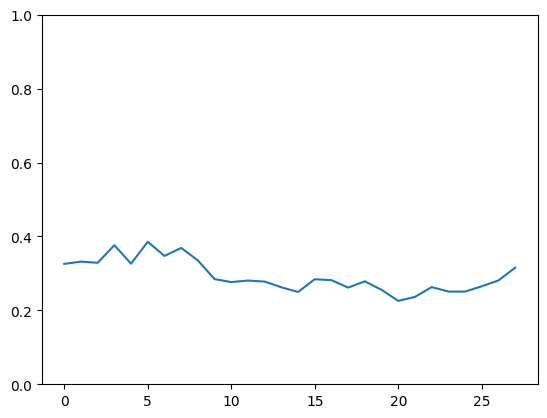

In [ ]:
avg_es_rfa = [np.mean(res_es_rfa[x]) for x in res_es_rfa.keys()]
plt.plot(avg_es_rfa)
plt.ylim(0,1)

In [ ]:
avg_es_rfa

[np.float64(0.3257718902314082),
 np.float64(0.33183060370086287),
 np.float64(0.32867018992879565),
 np.float64(0.37626533755766495),
 np.float64(0.32632644169165614),
 np.float64(0.3856167730010514),
 np.float64(0.3472446909041277),
 np.float64(0.36884146689304287),
 np.float64(0.3352674444771505),
 np.float64(0.28454303077555126),
 np.float64(0.27645780324736347),
 np.float64(0.2806697416934184),
 np.float64(0.2778173222289687),
 np.float64(0.2624226912456964),
 np.float64(0.24968924730118092),
 np.float64(0.28426755846345),
 np.float64(0.2816912845841476),
 np.float64(0.2615931921954533),
 np.float64(0.2784777110874919),
 np.float64(0.25544204976675766),
 np.float64(0.22566980421210503),
 np.float64(0.23642942799654393),
 np.float64(0.26299442158945435),
 np.float64(0.2508767154866032),
 np.float64(0.25078470546452863),
 np.float64(0.26519457948327596),
 np.float64(0.28092445389234594),
 np.float64(0.31552025821625396)]

### Compute Baseline Comps

In [ ]:
def generate_random_deltas(real_deltas, match_norm: bool = True):
    """
    Given real_deltas: dict[name → ΔW_tensor], returns a new dict
    of the same keys where each ΔW is replaced by a random tensor.

    If match_norm=True, each random ΔW is rescaled to have the same
    Frobenius norm as the corresponding real ΔW.
    """
    random_deltas = {}
    for k, v in real_deltas.items():
        # draw from N(0,1)
        rd = torch.randn_like(v)
        if match_norm:
            # avoid division by zero
            r_norm = rd.norm()
            if r_norm > 0:
                rd = rd * (v.norm() / r_norm)
        random_deltas[k] = rd
    return random_deltas

In [ ]:
def compute_cosine_similarity_baseline(mo_bma_id, k=20, match_norm=True):
    """
    For each layer in mo_model_A, compute cosine similarities between
    its top-k PCs and the top-k PCs of a random-delta baseline.

    - match_norm: if True, each random ΔW is scaled to have the same
      Frobenius norm as the real ΔW.
    """
    # real deltas
    mo_model_A = load_mo(mo_bma_id)
    deltas_A = get_delta_W(mo_model_A)

    del mo_model_A
    gc.collect()
    torch.cuda.empty_cache()

    # free_gpu()
    print("Made it A")

    top_k_pcs_A = {
      L: top_k_pcs(W.to('cuda'), k) for L, W in deltas_A.items()
    }

    print("Made it A2")


    # --------------------

    # random baselines
    deltas_rand = generate_random_deltas(deltas_A, match_norm=match_norm)

    del deltas_A
    gc.collect()
    torch.cuda.empty_cache()

    # compute top-k PCs
    top_k_rand = {L: top_k_pcs(W.to('cuda'), k) for L, W in deltas_rand.items()}

    del deltas_rand
    gc.collect()
    torch.cuda.empty_cache()

    # cosine similarities per layer
    sims = defaultdict(list)
    for layer in top_k_pcs_A.keys() & top_k_rand.keys():
        sims[layer] = cosine_similarity_torch(top_k_pcs_A[layer],
                                              top_k_rand[layer])
    return sims


### Qwen 7B

#### BMA

In [ ]:
bma_base = compute_cosine_similarity_baseline(mo_bma_id)

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.33G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/858 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/323M [00:00<?, ?B/s]

Made it A
Made it A2


In [ ]:
bma_base

defaultdict(list,
            {'base_model.model.model.layers.5.mlp.up_proj': tensor([-0.0232,  0.0105,  0.0108, -0.0078, -0.0088, -0.0028, -0.0013,  0.0128,
                     -0.0074,  0.0073, -0.0063,  0.0121, -0.0303, -0.0106,  0.0169, -0.0082,
                     -0.0196,  0.0174,  0.0036, -0.0382], device='cuda:0'),
             'base_model.model.model.layers.7.mlp.gate_proj': tensor([ 0.0366, -0.0359,  0.0095, -0.0252, -0.0010,  0.0177,  0.0046,  0.0050,
                      0.0063, -0.0038,  0.0099,  0.0530,  0.0125,  0.0192, -0.0156, -0.0106,
                      0.0310,  0.0147,  0.0118,  0.0050], device='cuda:0'),
             'base_model.model.model.layers.7.self_attn.v_proj': tensor([ 0.0257, -0.0208,  0.0211,  0.0197, -0.0314,  0.0236,  0.0026,  0.0041,
                     -0.0131,  0.0120,  0.0102,  0.0135,  0.0033, -0.0105, -0.0055,  0.0200,
                     -0.0264, -0.0075, -0.0041,  0.0197], device='cuda:0'),
             'base_model.model.model.layers.10.m

In [ ]:
res_bma_base = process_results(bma_base, max_layer=27)

In [ ]:
res_bma_base

{'layers.0': (np.float64(0.011669445782899857),
  np.float64(0.014301214500197343),
  np.float64(0.01766872505790421),
  np.float64(0.018731187530128018),
  np.float64(0.017995264880093082),
  np.float64(0.01591888500843197),
  np.float64(0.010653338128966945),
  np.float64(0.012218143957267915),
  np.float64(0.015215919286544834),
  np.float64(0.00966200977563858),
  np.float64(0.011772748615060533),
  np.float64(0.011517446621188096),
  np.float64(0.01575779525696167),
  np.float64(0.007438221148082188),
  np.float64(0.009354995364057166),
  np.float64(0.017276397041444267),
  np.float64(0.005404957004689744),
  np.float64(0.01053082856482693),
  np.float64(0.009988120357905115),
  np.float64(0.009009967325255275)),
 'layers.1': (np.float64(0.008991063206589647),
  np.float64(0.006917472197008985),
  np.float64(0.011901500767895154),
  np.float64(0.00980474690108427),
  np.float64(0.007352433466751661),
  np.float64(0.010666494756670935),
  np.float64(0.014749880880117416),
  np.floa

In [ ]:
avg_bma_base = [np.mean(res_bma_base[x]) for x in res_bma_base.keys()]
avg_bma_base

[np.float64(0.012604280560377185),
 np.float64(0.01214462289187525),
 np.float64(0.010377858486026525),
 np.float64(0.011502389552437566),
 np.float64(0.011129913746429207),
 np.float64(0.01324512370629236),
 np.float64(0.013285734802983437),
 np.float64(0.012212504192887406),
 np.float64(0.01314725987779509),
 np.float64(0.012687044676360008),
 np.float64(0.010934396785783717),
 np.float64(0.013249955978244545),
 np.float64(0.013296853802499491),
 np.float64(0.0124429627878791),
 np.float64(0.011999736766197852),
 np.float64(0.012556402273808739),
 np.float64(0.012095633554937583),
 np.float64(0.012165079087467997),
 np.float64(0.011428628338866733),
 np.float64(0.01210209080932795),
 np.float64(0.013298827326590462),
 np.float64(0.012693673748955397),
 np.float64(0.012302179920620151),
 np.float64(0.01123208885879389),
 np.float64(0.011765709940976064),
 np.float64(0.011219390749465676),
 np.float64(0.01160499787781321),
 np.float64(0.010638735967222602)]

#### ES

In [ ]:
es_base = compute_cosine_similarity_baseline(mo_es_id)

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.33G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/858 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/323M [00:00<?, ?B/s]

Made it A
Made it A2


In [ ]:
es_base

defaultdict(list,
            {'base_model.model.model.layers.27.mlp.down_proj': tensor([ 0.0039, -0.0048,  0.0110,  0.0078,  0.0010,  0.0035, -0.0016, -0.0093,
                     -0.0140, -0.0007,  0.0102, -0.0017, -0.0066,  0.0024, -0.0014,  0.0006,
                     -0.0055, -0.0115, -0.0132,  0.0059], device='cuda:0'),
             'base_model.model.model.layers.4.mlp.up_proj': tensor([-1.1364e-02,  2.4338e-03, -2.3190e-02, -9.0953e-03,  2.1788e-02,
                      1.6719e-02, -2.3915e-02, -2.6076e-02, -2.6289e-02,  2.2377e-02,
                      1.5851e-02, -6.0190e-03,  1.0421e-02, -2.1291e-02, -1.0040e-02,
                     -8.9401e-04,  1.9653e-02, -3.2251e-02, -5.8130e-05, -8.7990e-04],
                    device='cuda:0'),
             'base_model.model.model.layers.21.self_attn.k_proj': tensor([ 0.0193, -0.0080,  0.0136,  0.0066, -0.0037,  0.0090, -0.0006, -0.0121,
                     -0.0156,  0.0097, -0.0067,  0.0087, -0.0235,  0.0014, -0.0240,  0.0239,
 

In [ ]:
res_es_base = process_results(es_base, max_layer=27)

In [ ]:
res_es_base

{'layers.0': (np.float64(0.01509958359279803),
  np.float64(0.014979464966537697),
  np.float64(0.008233393209853343),
  np.float64(0.01562458323314786),
  np.float64(0.008485420141369104),
  np.float64(0.009087527204038841),
  np.float64(0.010895056217642767),
  np.float64(0.013661019304501159),
  np.float64(0.011767304835042782),
  np.float64(0.010376219737476535),
  np.float64(0.013577683296586786),
  np.float64(0.012807807086833886),
  np.float64(0.008338662063969033),
  np.float64(0.009743201712678586),
  np.float64(0.008618512789585761),
  np.float64(0.010953504126518965),
  np.float64(0.01206743624061346),
  np.float64(0.011246897812400545),
  np.float64(0.01168857145655368),
  np.float64(0.010069724039307662)),
 'layers.1': (np.float64(0.009734796293612038),
  np.float64(0.013872077039975141),
  np.float64(0.012849996531648296),
  np.float64(0.01248798190083887),
  np.float64(0.01741031976416707),
  np.float64(0.015156580002180167),
  np.float64(0.014037032478622027),
  np.floa

In [ ]:
avg_es_base = [np.mean(res_es_base[x]) for x in res_es_base.keys()]
avg_es_base

[np.float64(0.011366078653372825),
 np.float64(0.012310773261456884),
 np.float64(0.01268422299680034),
 np.float64(0.012411979442029927),
 np.float64(0.011437661546265842),
 np.float64(0.01244914126956636),
 np.float64(0.01144706032313739),
 np.float64(0.010476309353751795),
 np.float64(0.012025993569321665),
 np.float64(0.012670732563960235),
 np.float64(0.011581373451710012),
 np.float64(0.012409914243367634),
 np.float64(0.011907500347920827),
 np.float64(0.013560658795592775),
 np.float64(0.011926535453780421),
 np.float64(0.015239615262752129),
 np.float64(0.01352334421577065),
 np.float64(0.013706514475468012),
 np.float64(0.013342443766305223),
 np.float64(0.012607914337422702),
 np.float64(0.012723803578410298),
 np.float64(0.011992154787627182),
 np.float64(0.010932834787360794),
 np.float64(0.01240345474133002),
 np.float64(0.012886402822914533),
 np.float64(0.011607570342935754),
 np.float64(0.01100880902460111),
 np.float64(0.012329056409154354)]

### The Rest

In [ ]:
def create_visualization(data):
    """
    One grouped bar chart, for any number of PCs.
    Bars will auto‐shrink to fit, and the figure will
    expand horizontally to preserve the trend.
    """
    layers = list(data.keys())
    num_layers = len(layers)
    num_pcs = len(next(iter(data.values())))
    pc_vals = [
        [data[layer][j] for layer in layers]
        for j in range(num_pcs)
    ]

    x = np.arange(num_layers)

    # total span of a group (in x‐units); shrink if too many PCs
    total_width = 0.8
    width = total_width / num_pcs

    # make the figure wider if you have many layers
    figsize = (max(10, num_layers * 0.3), 6)
    fig, ax = plt.subplots(figsize=figsize, dpi=100)

    # use a light alpha so overlapping bars don't overwhelm
    for j in range(num_pcs):
        offsets = (j - (num_pcs - 1) / 2) * width
        ax.bar(x + offsets, pc_vals[j], width,
               label=f'PC{j+1}', alpha=0.7, edgecolor='none')

    ax.set_ylabel('Mean absolute value')
    ax.set_title('Per‑layer mean |PCₖ| for all PCs')
    ax.set_xticks(x)
    ax.set_xticklabels(layers, rotation=45, ha='right')

    # put legend outside to the right to avoid covering bars
    ax.legend(title='Principal components',
              ncol=min(4, num_pcs),
              fontsize='small',
              bbox_to_anchor=(1.02, 1),
              loc='upper left',
              borderaxespad=0.)

    plt.tight_layout()
    plt.show()

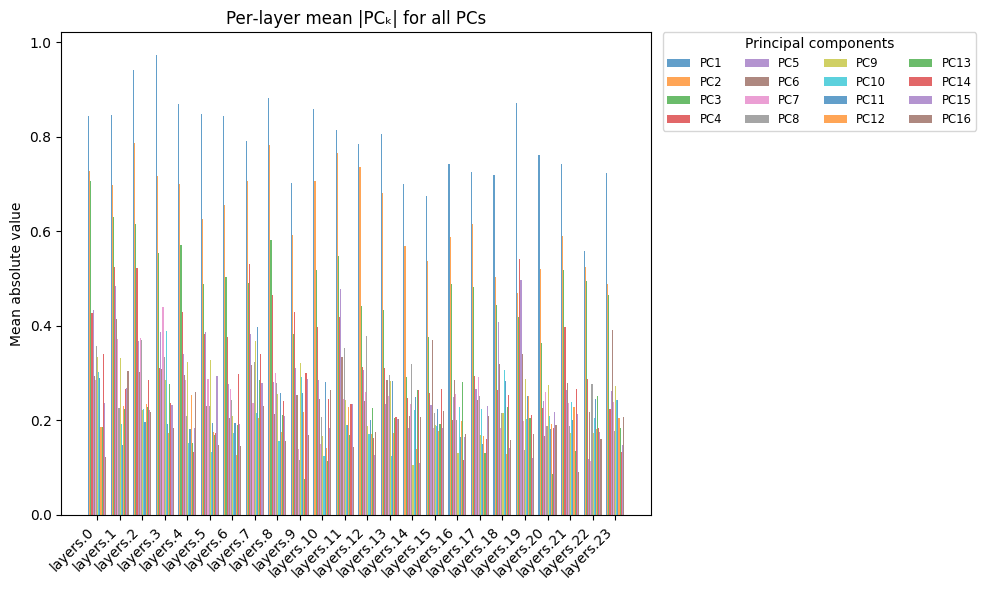

In [ ]:
create_visualization(res_bma_es)

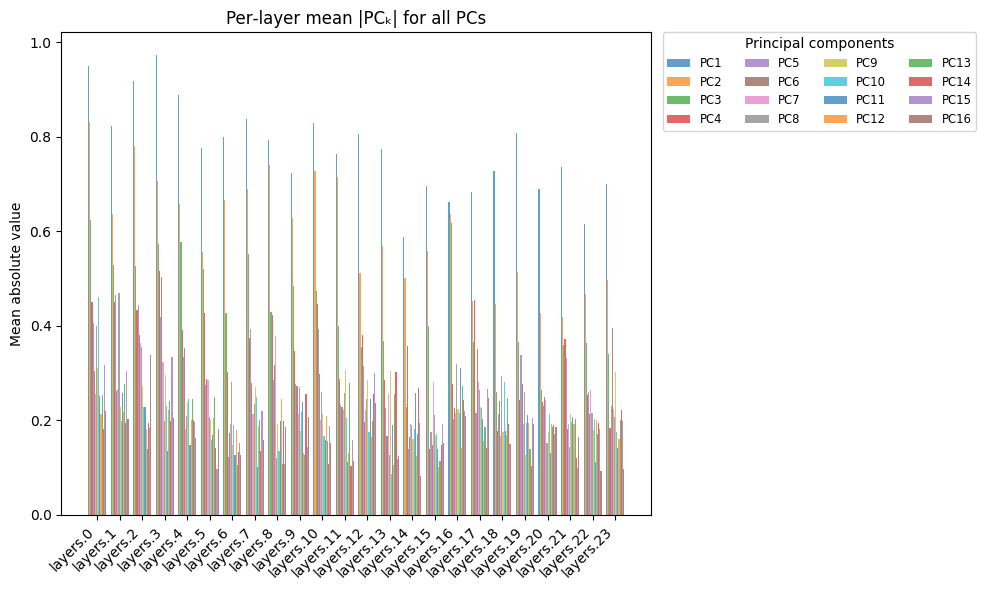

In [ ]:
create_visualization(res_bma_rfa)

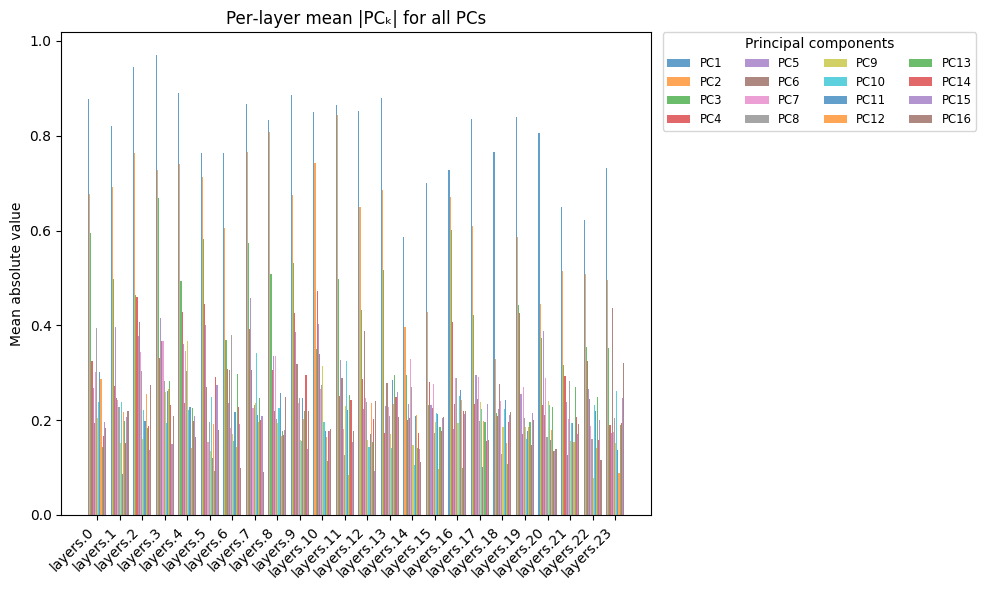

In [ ]:
create_visualization(res_es_rfa)

#### Random Baseline

In [ ]:
def generate_random_deltas(real_deltas, match_norm: bool = True):
    """
    Given real_deltas: dict[name → ΔW_tensor], returns a new dict
    of the same keys where each ΔW is replaced by a random tensor.

    If match_norm=True, each random ΔW is rescaled to have the same
    Frobenius norm as the corresponding real ΔW.
    """
    random_deltas = {}
    for k, v in real_deltas.items():
        # draw from N(0,1)
        rd = torch.randn_like(v)
        if match_norm:
            # avoid division by zero
            r_norm = rd.norm()
            if r_norm > 0:
                rd = rd * (v.norm() / r_norm)
        random_deltas[k] = rd
    return random_deltas

In [ ]:
def compute_cosine_similarity_baseline(mo_model_A, k=16, match_norm=True):
    """
    For each layer in mo_model_A, compute cosine similarities between
    its top-k PCs and the top-k PCs of a random-delta baseline.

    - match_norm: if True, each random ΔW is scaled to have the same
      Frobenius norm as the real ΔW.
    """
    # real deltas
    deltas_A = get_delta_W(mo_model_A)
    # random baselines
    deltas_rand = generate_random_deltas(deltas_A, match_norm=match_norm)

    # compute top-k PCs
    top_k_A    = {L: top_k_pcs(W, k) for L, W in deltas_A.items()}
    top_k_rand = {L: top_k_pcs(W, k) for L, W in deltas_rand.items()}

    # cosine similarities per layer
    sims = defaultdict(list)
    for layer in top_k_A.keys() & top_k_rand.keys():
        sims[layer] = cosine_similarity_torch(top_k_A[layer],
                                              top_k_rand[layer])
    return sims


In [ ]:
baseline_sims_bma = compute_cosine_similarity_baseline(mo_bma, k=16)
base_res_bma = process_results(baseline_sims_bma)

In [ ]:
base_res_bma

{'layers.0': (np.float64(0.01882102174152221),
  np.float64(0.015993115325857486),
  np.float64(0.014249147049018316),
  np.float64(0.034865241298185926),
  np.float64(0.02432543771075351),
  np.float64(0.026323324401995966),
  np.float64(0.016608645507533635),
  np.float64(0.039394195191562176),
  np.float64(0.018831934912928512),
  np.float64(0.019443035258778503),
  np.float64(0.021051699495209113),
  np.float64(0.02640374909554209),
  np.float64(0.01612531387114099),
  np.float64(0.023931017544652735),
  np.float64(0.01871779268341405),
  np.float64(0.026242861125086035)),
 'layers.1': (np.float64(0.030381643612469946),
  np.float64(0.026437949389219284),
  np.float64(0.018884683160909584),
  np.float64(0.030415754366133894),
  np.float64(0.02529551727431161),
  np.float64(0.02840972718383585),
  np.float64(0.03430806552725179),
  np.float64(0.025050340353378227),
  np.float64(0.022777626157871315),
  np.float64(0.030048728055719818),
  np.float64(0.028922971870218004),
  np.float6

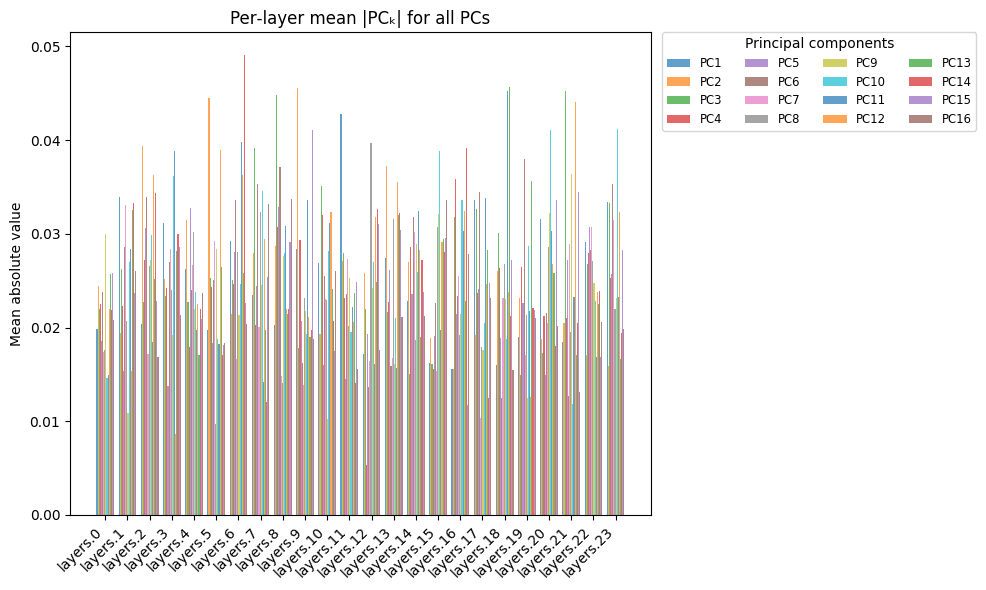

In [ ]:
create_visualization(base_res_bma)

In [ ]:
baseline_sims_rfa = compute_cosine_similarity_baseline(mo_rfa, k=16)
base_res_rfa = process_results(baseline_sims_rfa)

In [ ]:
base_res_rfa

{'layers.0': (np.float64(0.012381629353123052),
  np.float64(0.03831358320478882),
  np.float64(0.03548862299482737),
  np.float64(0.029982285041894232),
  np.float64(0.01931952897991453),
  np.float64(0.03510962812496083),
  np.float64(0.02493130256022726),
  np.float64(0.021810295725507394),
  np.float64(0.022331534585516368),
  np.float64(0.044171005354395936),
  np.float64(0.03075812105089426),
  np.float64(0.031750934797206094),
  np.float64(0.017283828662974492),
  np.float64(0.033552063895123344),
  np.float64(0.02193722767489297),
  np.float64(0.02341542110246207)),
 'layers.1': (np.float64(0.04403722605534962),
  np.float64(0.018827170665775026),
  np.float64(0.02946514529841287),
  np.float64(0.023835080276642526),
  np.float64(0.029264757675783976),
  np.float64(0.025919163067426),
  np.float64(0.02504601249737399),
  np.float64(0.028227396309375763),
  np.float64(0.01454045916242259),
  np.float64(0.027321554188217436),
  np.float64(0.02447340451180935),
  np.float64(0.0283

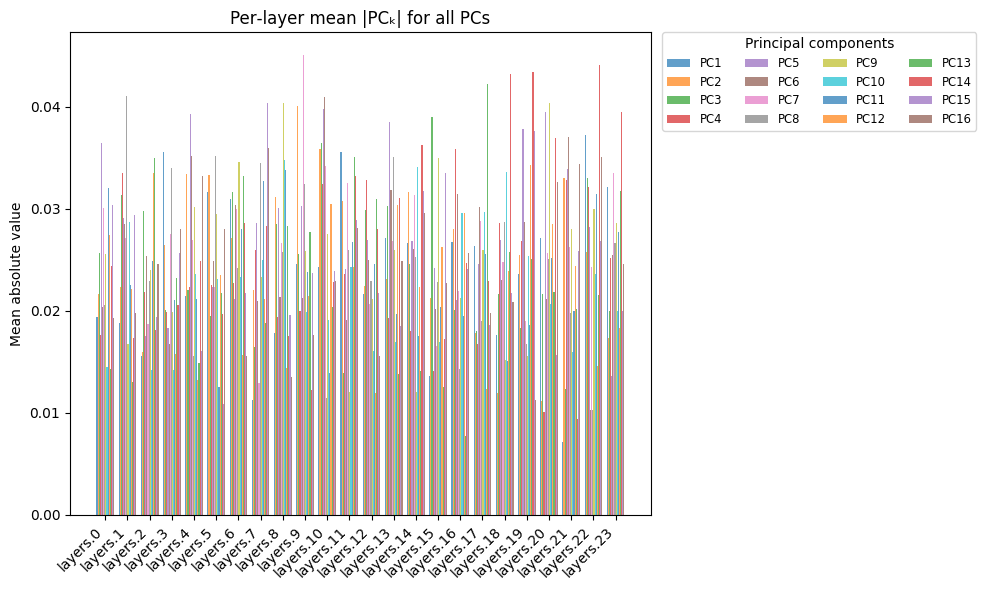

In [ ]:
create_visualization(base_res_rfa)

In [ ]:
baseline_sims_es = compute_cosine_similarity_baseline(mo_es, k=16)
base_res_es = process_results(baseline_sims_es)

In [ ]:
base_res_es

{'layers.0': (np.float64(0.020646154581169997),
  np.float64(0.021875852718949318),
  np.float64(0.02234964698020901),
  np.float64(0.04107735798295055),
  np.float64(0.02405752773795809),
  np.float64(0.025971113305006708),
  np.float64(0.031127458305231163),
  np.float64(0.03758973202535084),
  np.float64(0.008459101298025675),
  np.float64(0.0257921759704394),
  np.float64(0.01867576009993042),
  np.float64(0.016880403938038007),
  np.float64(0.030118862566139017),
  np.float64(0.03502815083733627),
  np.float64(0.020129675178655555),
  np.float64(0.026755628442125663)),
 'layers.1': (np.float64(0.023394118595336164),
  np.float64(0.029971222592783824),
  np.float64(0.02285580470093659),
  np.float64(0.023513012964810644),
  np.float64(0.025469754323629395),
  np.float64(0.022616707985954627),
  np.float64(0.024627359184835638),
  np.float64(0.016494613140821457),
  np.float64(0.021096395594733103),
  np.float64(0.03933422373873847),
  np.float64(0.019682813435792923),
  np.float64(

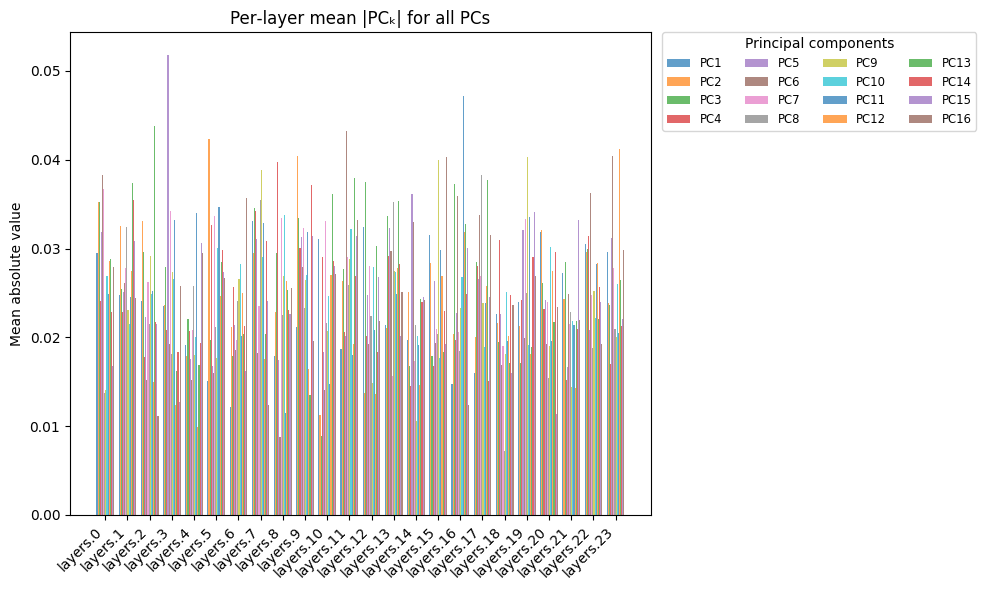

In [ ]:
create_visualization(base_res_es)

# Grassman Angle Calculations

In [ ]:
def compute_grassmann_angles(U1, U2):
    """
    Compute principal angles between two subspaces via SVD of U1^T @ U2
    Args:
        U1, U2: Orthonormal bases for subspaces (torch tensors)
    Returns:
        angles: Principal angles in radians
    """
    # Ensure same device
    U1, U2 = U1.to(U2.device), U2.to(U2.device)

    # Compute SVD of U1^T @ U2
    _, sigma, _ = torch.linalg.svd(U1.T @ U2)

    # Clamp to avoid numerical issues
    sigma = torch.clamp(sigma, 0, 1)

    # Principal angles
    angles = torch.acos(sigma)
    return angles

In [ ]:
def compute_grassmann_angles_across_mo_models(mo_model_A, mo_model_B, k=16):
    """
    For each layer, compute the principal angles between the top-k PCs
    of mo_model_A vs. mo_model_B.
    Returns: dict[layer → tensor of k angles (in radians)]
    """
    # get real deltas
    deltas_A = get_delta_W(mo_model_A)
    deltas_B = get_delta_W(mo_model_B)

    # extract top-k orthonormal PCs
    top_k_A = {L: top_k_pcs(W, k) for L, W in deltas_A.items()}
    top_k_B = {L: top_k_pcs(W, k) for L, W in deltas_B.items()}

    # compute principal angles
    angles = {}
    for layer in top_k_A.keys() & top_k_B.keys():
        U1, U2 = top_k_A[layer].T, top_k_B[layer].T
        angles[layer] = compute_grassmann_angles(U1, U2)
    return angles

In [ ]:
def process_grassman_results(angle_dict, min_layer=0, max_layer=23):
    """
    Groups principal angles (from compute_grassmann_angles_…) by layer index.

    Args:
        angle_dict: dict mapping full module-path names (e.g.
                    "…layers.0.self_attn") → 1D torch.Tensor of angles.
        min_layer, max_layer: integer bounds on layer IDs to include.

    Returns:
        final_dict: dict mapping "layers.i" → tuple of mean angles
                    for each principal-angle index j.
                    (If you only had one entry per layer, each tuple
                     will just be that layer’s angle vector.)
    """
    final_dict = {}
    for i in range(min_layer, max_layer + 1):
        prefix = f"layers.{i}."
        # build one growing list per angle-index
        angle_lists = []
        for name, angles in angle_dict.items():
            if prefix in name:
                for j, θ in enumerate(angles):
                    # extend on the fly if this layer has more angles
                    if j >= len(angle_lists):
                        angle_lists.append([])
                    angle_lists[j].append(θ.cpu().item())

        # take the mean over every collected list of angles
        if angle_lists:
            means = tuple(np.mean(lst) for lst in angle_lists)
        else:
            means = ()  # no entries for this layer
        final_dict[f"layers.{i}"] = means

    return final_dict

In [ ]:
def subspace_overlap_from_angles(angles: torch.Tensor) -> float:
    """
    Given a 1D tensor of principal angles θ₁…θₖ,
    returns the subspace‐overlap fraction: (1/k) ∑ cos²(θᵢ).
    """
    cos2 = torch.cos(angles).pow(2)
    return cos2.mean().item()

In [ ]:
# grass_bma_es.keys()
# grass_bma_es['base_model.model.model.layers.19.mlp.up_proj']

tensor([0.0000, 0.0203, 0.0529, 0.0813, 0.1118, 0.1176, 0.1985, 0.2471, 0.2908,
        0.3611, 0.3808, 0.4187, 0.5595, 0.7040, 0.8155, 1.5544],
       device='cuda:0')

In [ ]:
# cosine_sim_bma_es['base_model.model.model.layers.19.mlp.up_proj']

#### BMA - ES

In [ ]:
grass_bma_es = compute_grassmann_angles_across_mo_models(mo_bma, mo_es)
grass_res_bma_es = process_grassman_results(grass_bma_es)

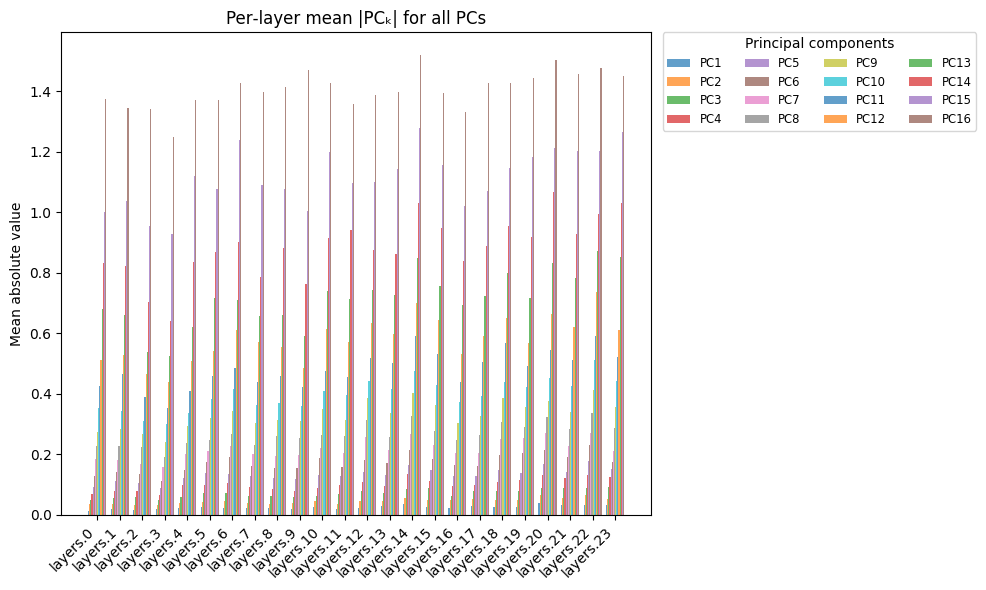

In [ ]:
create_visualization(grass_res_bma_es)

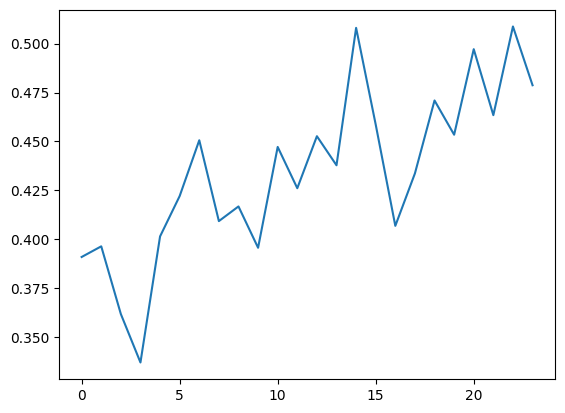

In [ ]:
avg_grass_bma_es = [np.mean(grass_res_bma_es[x]) for x in grass_res_bma_es.keys()]
plt.plot(avg_grass_bma_es)
# plt.ylim(0,1)

In [ ]:
# Suppose `grass_angles` is your dict[layer_name → 1D tensor of θ’s]
overlap_frac_bma_es = {
    layer: subspace_overlap_from_angles(ang)
    for layer, ang in grass_bma_es.items()
}

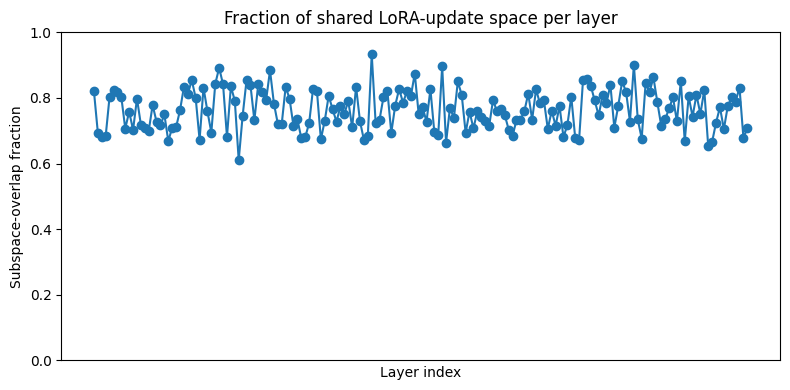

In [ ]:
# Now `overlap_frac[layer]` is in [0,1], e.g. 0.82 means ~82% shared subspace.
layers = list(overlap_frac_bma_es.keys())
vals   = [overlap_frac_bma_es[L] for L in layers]

# extract the integer layer index from each key:
# e.g. "…layers.19.mlp.up_proj" → 19
layer_nums = [int(L.split(".layers.")[1].split(".")[0]) for L in layers]

plt.figure(figsize=(8, 4))
plt.plot(range(len(layers)), vals, marker='o')
# now set ticks to those layer numbers
plt.xticks([])
plt.xlabel("Layer index")
plt.ylabel("Subspace-overlap fraction")
plt.title("Fraction of shared LoRA-update space per layer")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

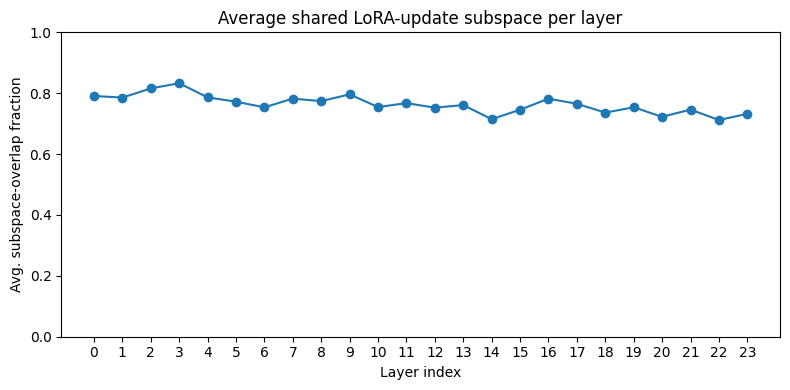

In [ ]:
# 1) Group values by layer index
per_layer = defaultdict(list)
for module_key, frac in overlap_frac_bma_es.items():
    # parse out the integer layer index, e.g. "…layers.19.mlp.…" → 19
    layer = int(module_key.split(".layers.")[1].split(".")[0])
    per_layer[layer].append(frac)

# 2) Compute the mean overlap for each layer
layer_idxs = sorted(per_layer.keys())
avg_overlap = [sum(per_layer[i]) / len(per_layer[i]) for i in layer_idxs]

# 3) Plot the result
plt.figure(figsize=(8, 4))
plt.plot(layer_idxs, avg_overlap, marker='o', linestyle='-')
plt.xticks(layer_idxs)               # ticks at 0,1,2,…,23
plt.xlabel("Layer index")
plt.ylabel("Avg. subspace-overlap fraction")
plt.title("Average shared LoRA-update subspace per layer")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

#### RFA - ES

In [ ]:
grass_rfa_es = compute_grassmann_angles_across_mo_models(mo_rfa, mo_es)
grass_res_rfa_es = process_results(grass_rfa_es)

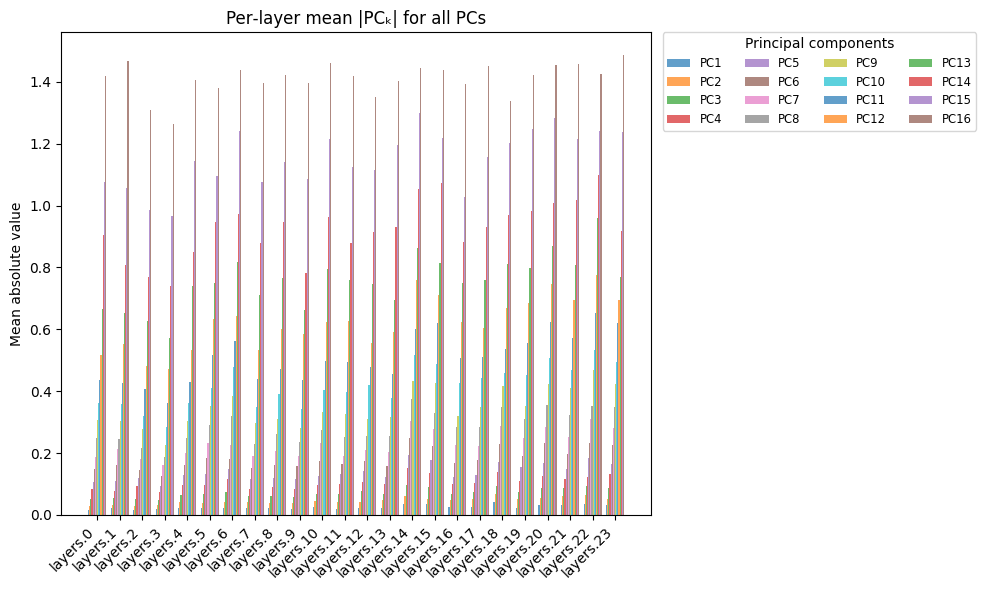

In [ ]:
create_visualization(grass_res_rfa_es)

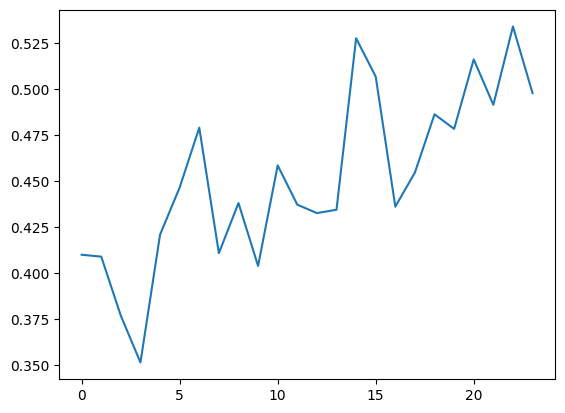

In [ ]:
avg_grass_rfa_es = [np.mean(grass_res_rfa_es[x]) for x in grass_res_rfa_es.keys()]
plt.plot(avg_grass_rfa_es)
# plt.ylim(0,1)

In [ ]:
# Suppose `grass_angles` is your dict[layer_name → 1D tensor of θ’s]
overlap_frac_rfa_es = {
    layer: subspace_overlap_from_angles(ang)
    for layer, ang in grass_rfa_es.items()
}

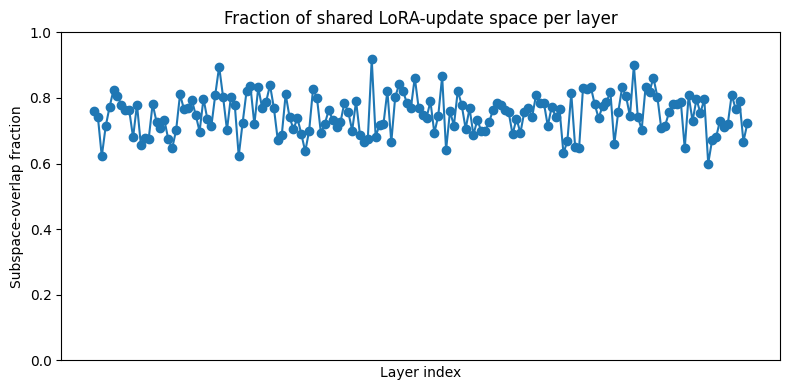

In [ ]:
# Now `overlap_frac[layer]` is in [0,1], e.g. 0.82 means ~82% shared subspace.
layers = list(overlap_frac_rfa_es.keys())
vals   = [overlap_frac_rfa_es[L] for L in layers]

# extract the integer layer index from each key:
# e.g. "…layers.19.mlp.up_proj" → 19
layer_nums = [int(L.split(".layers.")[1].split(".")[0]) for L in layers]

plt.figure(figsize=(8, 4))
plt.plot(range(len(layers)), vals, marker='o')
# now set ticks to those layer numbers
plt.xticks([])
plt.xlabel("Layer index")
plt.ylabel("Subspace-overlap fraction")
plt.title("Fraction of shared LoRA-update space per layer")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

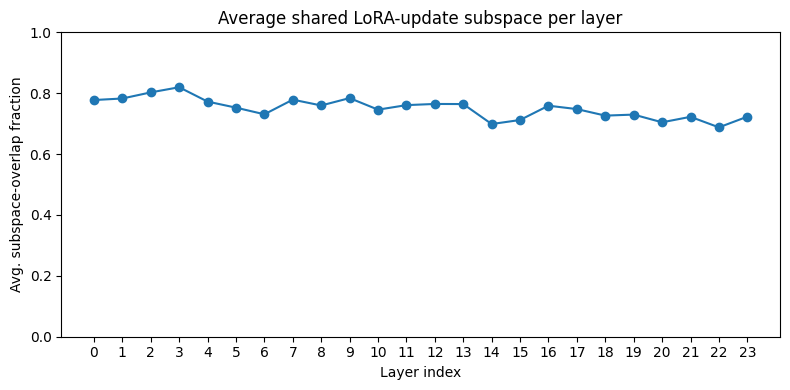

In [ ]:
# 1) Group values by layer index
per_layer = defaultdict(list)
for module_key, frac in overlap_frac_rfa_es.items():
    # parse out the integer layer index, e.g. "…layers.19.mlp.…" → 19
    layer = int(module_key.split(".layers.")[1].split(".")[0])
    per_layer[layer].append(frac)

# 2) Compute the mean overlap for each layer
layer_idxs = sorted(per_layer.keys())
avg_overlap = [sum(per_layer[i]) / len(per_layer[i]) for i in layer_idxs]

# 3) Plot the result
plt.figure(figsize=(8, 4))
plt.plot(layer_idxs, avg_overlap, marker='o', linestyle='-')
plt.xticks(layer_idxs)               # ticks at 0,1,2,…,23
plt.xlabel("Layer index")
plt.ylabel("Avg. subspace-overlap fraction")
plt.title("Average shared LoRA-update subspace per layer")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

#### BMA - RFA

In [ ]:
grass_bma_rfa = compute_grassmann_angles_across_mo_models(mo_rfa, mo_bma)
grass_res_bma_rfa = process_results(grass_bma_rfa)

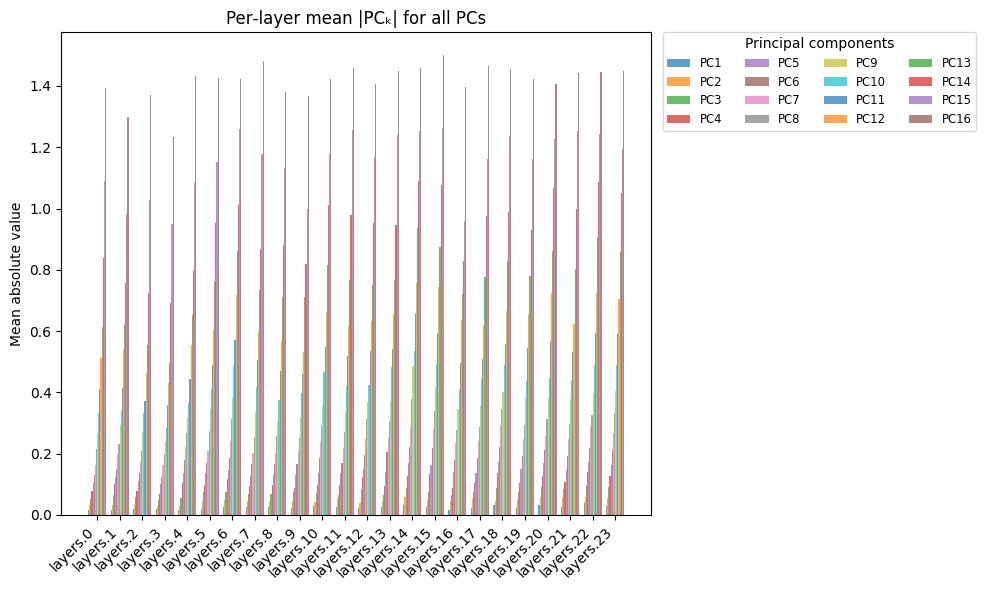

In [ ]:
create_visualization(grass_res_bma_rfa)

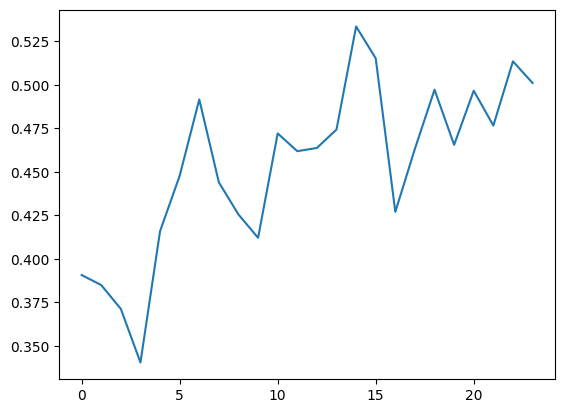

In [ ]:
avg_grass_bma_rfa = [np.mean(grass_res_bma_rfa[x]) for x in grass_res_bma_rfa.keys()]
plt.plot(avg_grass_bma_rfa)
# plt.ylim(0,1)

In [ ]:
# Suppose `grass_angles` is your dict[layer_name → 1D tensor of θ’s]
overlap_frac_bma_rfa = {
    layer: subspace_overlap_from_angles(ang)
    for layer, ang in grass_bma_rfa.items()
}

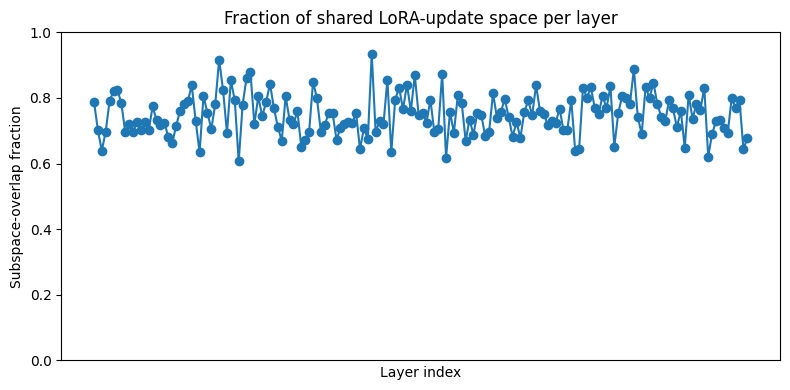

In [ ]:
# Now `overlap_frac[layer]` is in [0,1], e.g. 0.82 means ~82% shared subspace.
layers = list(overlap_frac_bma_rfa.keys())
vals   = [overlap_frac_bma_rfa[L] for L in layers]

# extract the integer layer index from each key:
# e.g. "…layers.19.mlp.up_proj" → 19
layer_nums = [int(L.split(".layers.")[1].split(".")[0]) for L in layers]

plt.figure(figsize=(8, 4))
plt.plot(range(len(layers)), vals, marker='o')
# now set ticks to those layer numbers
plt.xticks([])
plt.xlabel("Layer index")
plt.ylabel("Subspace-overlap fraction")
plt.title("Fraction of shared LoRA-update space per layer")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

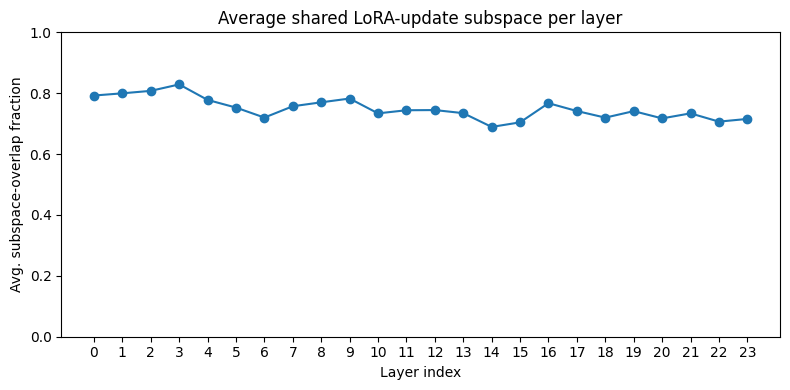

In [ ]:
# 1) Group values by layer index
per_layer = defaultdict(list)
for module_key, frac in overlap_frac_bma_rfa.items():
    # parse out the integer layer index, e.g. "…layers.19.mlp.…" → 19
    layer = int(module_key.split(".layers.")[1].split(".")[0])
    per_layer[layer].append(frac)

# 2) Compute the mean overlap for each layer
layer_idxs = sorted(per_layer.keys())
avg_overlap = [sum(per_layer[i]) / len(per_layer[i]) for i in layer_idxs]

# 3) Plot the result
plt.figure(figsize=(8, 4))
plt.plot(layer_idxs, avg_overlap, marker='o', linestyle='-')
plt.xticks(layer_idxs)               # ticks at 0,1,2,…,23
plt.xlabel("Layer index")
plt.ylabel("Avg. subspace-overlap fraction")
plt.title("Average shared LoRA-update subspace per layer")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

#### Random Grassman angles baseline

In [ ]:
def compute_grassmann_angles_baseline(mo_model_A, k=16, match_norm=True):
    """
    For each layer in mo_model_A, compute the principal angles between
    its top-k PCs and the top-k PCs of a random‐delta baseline.
    """
    # real deltas + random‐baseline deltas
    deltas_A    = get_delta_W(mo_model_A)
    deltas_rand = generate_random_deltas(deltas_A, match_norm=match_norm)

    # top-k subspace bases
    top_k_A    = {L: top_k_pcs(W, k) for L, W in deltas_A.items()}
    top_k_rand = {L: top_k_pcs(W, k) for L, W in deltas_rand.items()}

    # principal angles per layer
    angles = {}
    for layer in top_k_A.keys() & top_k_rand.keys():
        U1, U2 = top_k_A[layer].T, top_k_rand[layer].T
        angles[layer] = compute_grassmann_angles(U1, U2)
    return angles

In [ ]:
baseline_grass_es = compute_grassmann_angles_baseline(mo_es, k=16)
base_grass_res_es = process_results(baseline_grass_es)

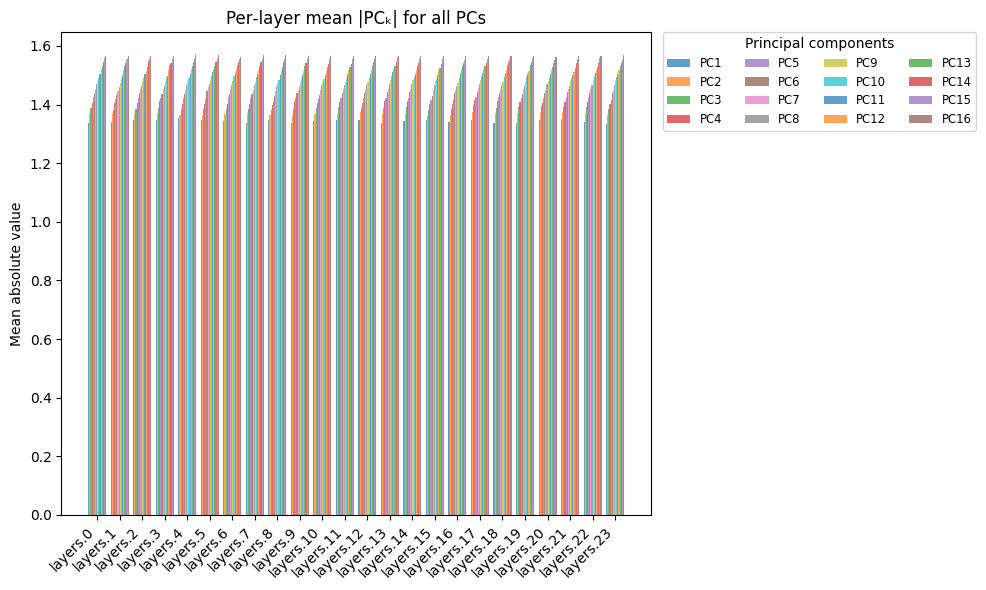

In [ ]:
create_visualization(base_grass_res_es)

In [ ]:
baseline_grass_rfa = compute_grassmann_angles_baseline(mo_rfa, k=16)
base_grass_res_rfa = process_results(baseline_grass_rfa)

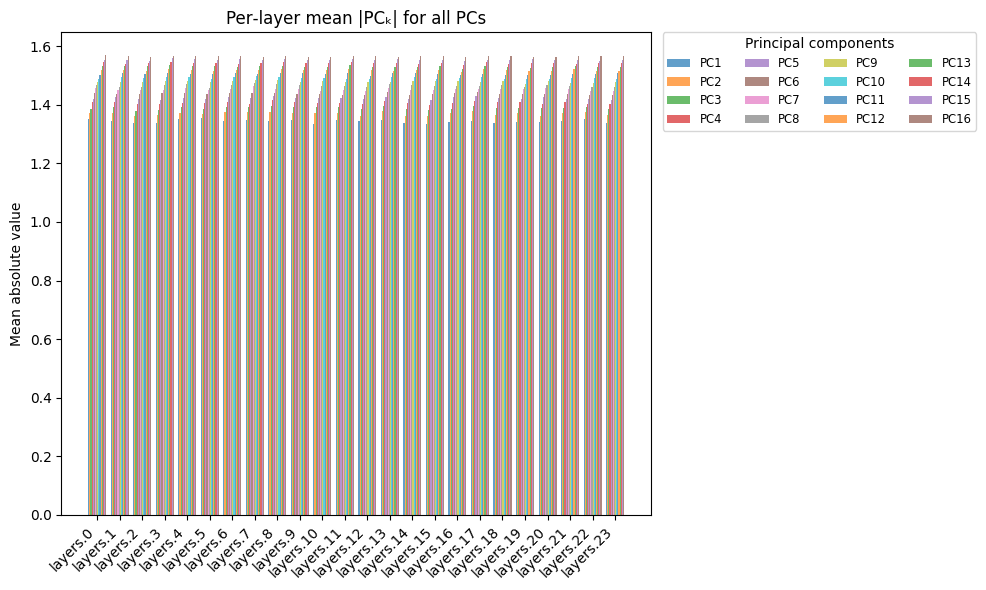

In [ ]:
create_visualization(base_grass_res_rfa)

In [ ]:
baseline_grass_bma = compute_grassmann_angles_baseline(mo_bma, k=16)
base_grass_res_bma = process_results(baseline_grass_bma)

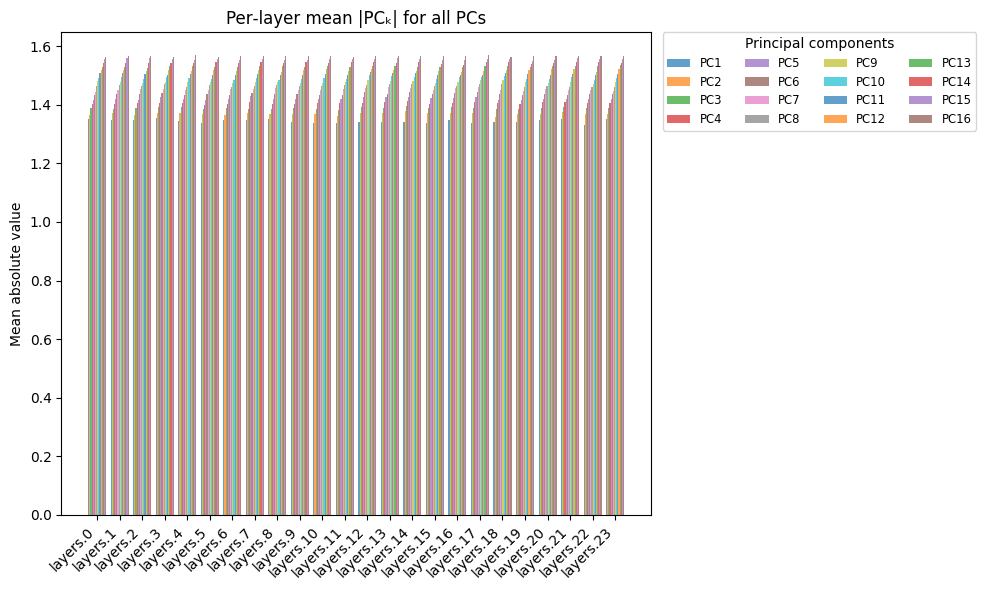

In [ ]:
create_visualization(base_grass_res_bma)

(0.0, 1.58)

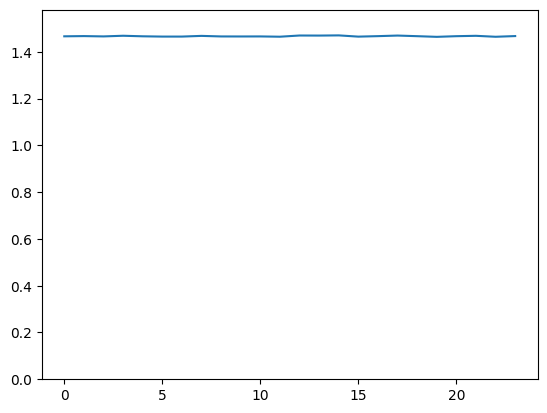

In [ ]:
avg_base_grass_bma = [np.mean(base_grass_res_bma[x]) for x in base_grass_res_bma.keys()]
plt.plot(avg_base_grass_bma)
plt.ylim(0,1.58)

In [ ]:
# Suppose `grass_angles` is your dict[layer_name → 1D tensor of θ’s]
overlap_frac_base_bma = {
    layer: subspace_overlap_from_angles(ang)
    for layer, ang in baseline_grass_bma.items()
}

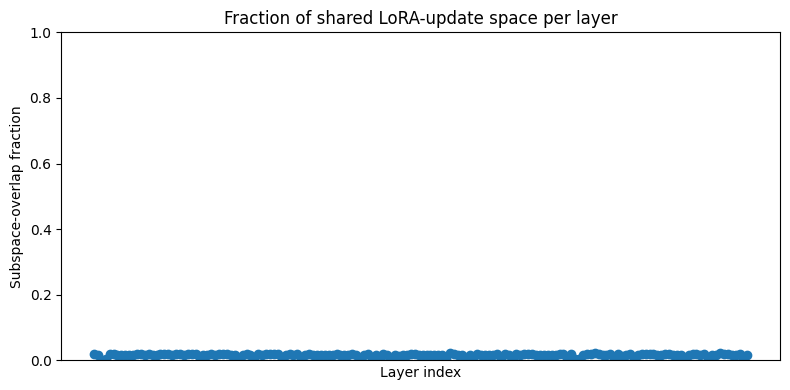

In [ ]:
# Now `overlap_frac[layer]` is in [0,1], e.g. 0.82 means ~82% shared subspace.
layers = list(overlap_frac_base_bma.keys())
vals   = [overlap_frac_base_bma[L] for L in layers]

# extract the integer layer index from each key:
# e.g. "…layers.19.mlp.up_proj" → 19
layer_nums = [int(L.split(".layers.")[1].split(".")[0]) for L in layers]

plt.figure(figsize=(8, 4))
plt.plot(range(len(layers)), vals, marker='o')
# now set ticks to those layer numbers
plt.xticks([])
plt.xlabel("Layer index")
plt.ylabel("Subspace-overlap fraction")
plt.title("Fraction of shared LoRA-update space per layer")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

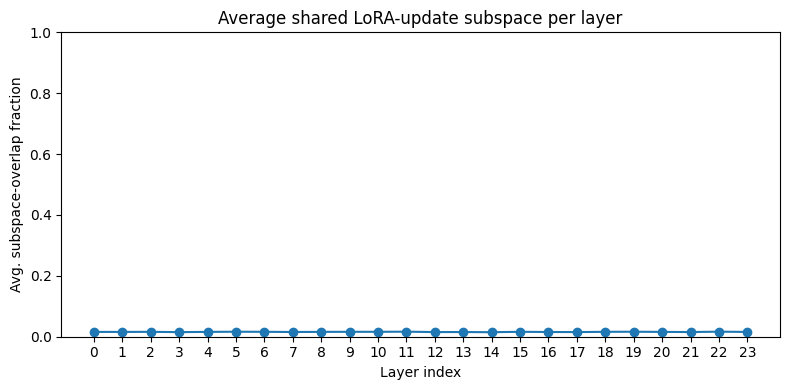

In [ ]:
# 1) Group values by layer index
per_layer = defaultdict(list)
for module_key, frac in overlap_frac_base_bma.items():
    # parse out the integer layer index, e.g. "…layers.19.mlp.…" → 19
    layer = int(module_key.split(".layers.")[1].split(".")[0])
    per_layer[layer].append(frac)

# 2) Compute the mean overlap for each layer
layer_idxs = sorted(per_layer.keys())
avg_overlap = [sum(per_layer[i]) / len(per_layer[i]) for i in layer_idxs]

# 3) Plot the result
plt.figure(figsize=(8, 4))
plt.plot(layer_idxs, avg_overlap, marker='o', linestyle='-')
plt.xticks(layer_idxs)               # ticks at 0,1,2,…,23
plt.xlabel("Layer index")
plt.ylabel("Avg. subspace-overlap fraction")
plt.title("Average shared LoRA-update subspace per layer")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()